In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import beta

In [2]:
%matplotlib inline

In [3]:
class Person:
    
    class Relationship:
        
        def __init__(self, other, freq, magnitude, trust):
            self.other = other # another Person with from whom this Person will receive information
            self.frequency = freq # the probability of communicating with the other Person on a given timestep
            self.magnitude = magnitude # the amount of information received when communicating
            self.trust = trust # the extent to which this Person trusts the other Person
    
    def __init__(self, alpha, beta, open_mindedness=1,  id_num = 1):
        self.id = id_num
        self.alpha = alpha
        self.beta = beta
        self.open_mindedness = open_mindedness
        self.relationships = set()
        self.historical_alphas = {0 : self.alpha}
        self.historical_betas = {0 : self.beta}
        
    def add_relationship(self, other, freq, mag=10, trust=1):
        self.relationships.add(self.Relationship(other, freq, mag, trust))
        
    def sample_beliefs(self, num_samples):
        sample = stats.beta.rvs(self.alpha, self.beta, size=num_samples)
        # this commented out line would make it more compatible with update_beliefs_2
        # sample = [stats.bernoulli.rvs(data) for data in sample]
        return sample
    
    def plot_beliefs(self, ax=plt, t=-1, style="", legend=""):
        x = np.arange(0,1,0.01)
        if ax != plt:
          ax.set_xticks(np.arange(0,1.01,0.1))
        if t == -1:
          a = self.alpha
          b = self.beta
        elif t in self.historical_alphas.keys() and t in self.historical_betas.keys():
          a = self.historical_alphas[t]
          b = self.historical_betas[t]
        else:
          print(f"Parameters were not saved for t={t}")
          return
        if legend == "":
          label = f"a={a:.1f}, b={b:.1f}"
          ax.plot(x, stats.beta.pdf(x, a, b), style, label=label)
          # ax.set_ylim(top = max(stats.beta.pdf(x, a, b) + 0.1))
        if legend != False:
          ax.plot(x, stats.beta.pdf(x, a, b), style, label=legend)
          # ax.set_ylim(top = max(stats.beta.pdf(x, a, b) + 0.1))
          ax.legend()
        
    def get_mean_belief(self):
        return stats.beta.mean(self.alpha, self.beta)
        
    def update_beliefs(self, evidence, trust):
        # based on Marcelo's implementation
        threshold = self.sample_beliefs(1)[0]
        for data in evidence:
            if data > threshold:
                self.alpha = (self.alpha + self.open_mindedness * trust * data)
                
            if data == threshold:
                self.alpha = self.alpha + self.open_mindedness * trust * data
                self.beta = self.beta + self.open_mindedness * trust * data

            if data < threshold:
                self.beta = self.beta + self.open_mindedness * trust * (1-data)

    def update_beliefs2(self, evidence, trust):
        # another idea I had
        evidence = [stats.bernoulli.rvs(data) for data in evidence]
        
        y = sum(evidence)
        
        # update alpha
        self.alpha += self.open_mindedness * trust * y
        
        # update beta
        self.beta += self.open_mindedness * trust * (len(evidence) - y)

    def recalibrate_beliefs(self, other):
        self_n = self.alpha + self.beta
        other_n = other.alpha + other.beta
        new_n = 0.95 * self_n + 0.05 * other_n

        self.alpha *= new_n / self_n
        self.beta *= new_n / self_n

    def save_params(self, t):
        self.historical_alphas[t] = self.alpha
        self.historical_betas[t] = self.beta
    
    def perform_time_step2(self):
        for relationship in self.relationships:
            if np.random.rand() < relationship.frequency:
                self.update_beliefs(evidence=relationship.other.sample_beliefs(relationship.magnitude), trust=relationship.trust)
                self.recalibrate_beliefs(relationship.other)
    def perform_time_step(self):
        for relationship in self.relationships:
            if np.random.rand() < relationship.frequency:
                self.update_beliefs2(evidence=relationship.other.sample_beliefs(relationship.magnitude), trust=relationship.trust)
                self.recalibrate_beliefs(relationship.other) 

In [4]:
def run_simulation(people, recording_people, tstop, recording_times):
  for t in range(1, tstop + 1):
    for person in people:
      person.perform_time_step()
      if person in recording_people and t in recording_times:
        person.save_params(t)

In [5]:
def plot_beta(a, b, title = 'No Title', style = 'black'):
    theta_range = np.arange(0,1,0.001)
    theta_plot_range = np.arange(0,1.01,0.1)
    plt.xticks(theta_plot_range)
    plt.plot(theta_range, beta.pdf(theta_range,a , b), style)
    plt.title(title)
    plt.show

### Network Visualization

In [6]:
!pip install daft

In [7]:
from daft import PGM

In [8]:
def visualize_network(people):
    network = PGM()
    
    size = (np.sqrt(len(people)) + 0.5) // 1
    
    for i in range(len(people)):
        network.add_node(people[i].id, people[i].id, i // size, i % size)
    
    for p in people:
        for r in p.relationships:
            network.add_edge(r.other.id, p.id)
    
    network.render()
    plt.show()

In [9]:
!pip install pyvis

In [10]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

In [11]:
def create_edge_df(people):
    sources = []
    targets = []
    trusts = []
    
    for person in people:
        for r in person.relationships:
            sources.append(r.other.id)
            targets.append(person.id)
            trusts.append(r.trust)
            
    df = pd.DataFrame({"Source": sources, "Target": targets, "Trust": trusts})
    return df
    
def visualize_network2(people):
    df = create_edge_df(people)
    D = nx.DiGraph()
    D.add_nodes_from([p.id for p in people])
    for person in people:
        for r in person.relationships:
            D.add_edge(r.other.id, person.id)
    G = nx.from_pandas_edgelist(df, source="Source", target="Target", edge_attr="Trust")
    
    # nx.draw_networkx(D, arrows=True)
    net = Network(notebook=True, cdn_resources='in_line')
    net.from_nx(G)
    net.show_buttons(filter_=['physics'])
    html = net.generate_html()
    with open("example.html", mode='w', encoding='utf-8') as fp:
        fp.write(html)
    display(HTML(html))

#### Net visualization testing

In [12]:
people = []
for i in range(1,26):
    people.append(Person(np.random.rand() * 20, np.random.rand() * 20, id_num=i))
    
for i in range(25):
    for j in range(5):
        other = np.random.randint(1, 25)
        if other != i:
            people[i].add_relationship(people[other], 1)

visualize_network2(people)

### One source: Playing with open-mindedness

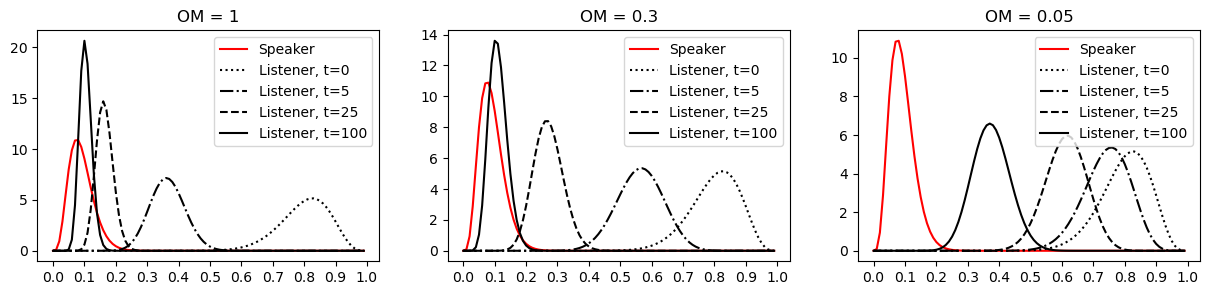

In [13]:
source = Person(5, 50)

oms = [1, 0.3, 0.05]

target_1 = Person(20, 5, 1)
target_2 = Person(20, 5, 0.3)
target_3 = Person(20, 5, 0.05)

targets = [target_1, target_2, target_3]

for p in targets:
  p.add_relationship(source, 1, trust=1)

recording_times = [0, 5, 25, 100]

run_simulation(targets, targets, 100, recording_times)

fig, axes = plt.subplots(1, 3, figsize=(15,3))

styles = [":", "-.", "--", "-"]

for i, ax in enumerate(axes):
  source.plot_beliefs(ax, style="r", legend="Speaker")
  ax.set_title(f"OM = {oms[i]}")
  for j, t in enumerate(recording_times):
    targets[i].plot_beliefs(ax, t, style='k'+styles[j], legend=f"Listener, t={t}")

### One source: Playing with trust

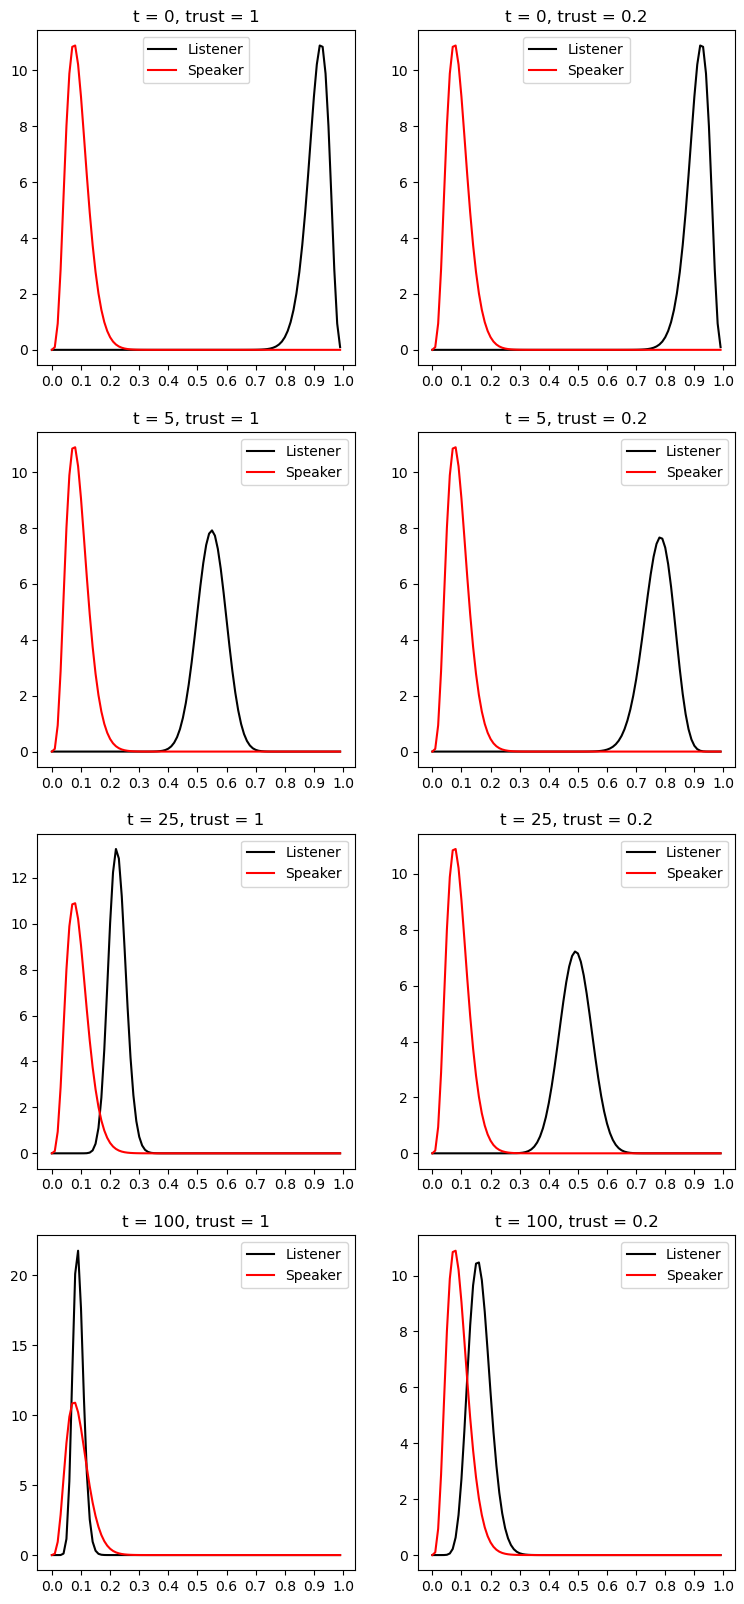

In [14]:
# For the plots with trust = 1

target_1 = Person(50, 5)

source_1 = Person(5, 50)

target_1.add_relationship(source_1, 1, trust = 1)

recorded_times = [0, 5, 25, 100]

for t in range(1,101):
    target_1.perform_time_step()
    if t in recorded_times:
        target_1.save_params(t)

# For the plots with trust = 0.2

target_2 = Person(50, 5)

source_2 = Person(5, 50)

target_2.add_relationship(source_2, 1, trust = 0.2)

for t in range(1,101):
    target_2.perform_time_step()
    if t in recorded_times:
        target_2.save_params(t)

# Plotting

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(9, 20))

for i, t in enumerate(recorded_times):
  target_1.plot_beliefs(ax[i,0], t, style = "k", legend = "Listener")
  source_1.plot_beliefs(ax[i,0], style='r', legend="Speaker")
  ax[i,0].set_title(f't = {t}, trust = 1')

  target_2.plot_beliefs(ax[i,1], t, "k", "Listener")
  source_2.plot_beliefs(ax[i,1], style='r', legend="Speaker")
  ax[i,1].set_title(f't = {t}, trust = 0.2')

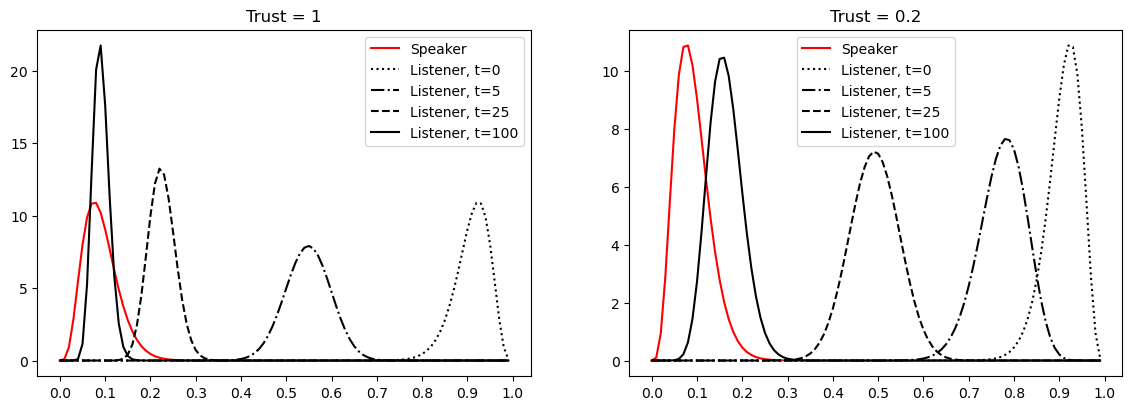

In [15]:
# NOTE: Creates condensed plot for people in cell above
# RUN CELL ABOVE THIS FIRST

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4.5))

ax[0].set_title('Trust = 1')
ax[1].set_title('Trust = 0.2')

source_1.plot_beliefs(ax[0], style='r', legend="Speaker")
source_2.plot_beliefs(ax[1], style='r', legend="Speaker")

styles = [':', '-.', '--', '-']

for i, t in enumerate(recorded_times):
  target_1.plot_beliefs(ax[0], t, "k"+styles[i%len(styles)], f"Listener, t={t}")
  target_2.plot_beliefs(ax[1], t, "k"+styles[i%len(styles)], f"Listener, t={t}")

### Trust from two sources

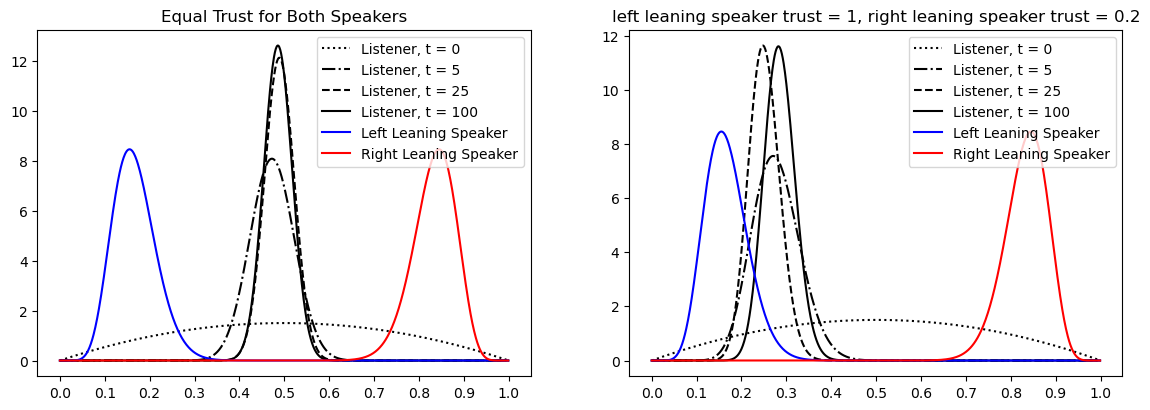

In [16]:
# For the plots with trust = 1

target_1 = Person(2, 2)

left_source_1 = Person(10, 50)
right_source_1 = Person(50, 10)

target_1.add_relationship(left_source_1, 1, trust = 1)
target_1.add_relationship(right_source_1, 1, trust = 1)

target_1_alphas = [target_1.alpha]
target_1_betas = [target_1.beta]

for t in range(1,101):
    target_1.perform_time_step()
    if t in [5, 25, 100]:
        target_1_alphas.append(target_1.alpha)
        target_1_betas.append(target_1.beta)

# For the plots with trust = 0.2

target_2 = Person(2, 2)

left_source_2 = Person(10, 50)
right_source_2 = Person(50, 10)

target_2.add_relationship(left_source_2, 1, trust = 1)
target_2.add_relationship(right_source_2, 1, trust = 0.2)

target_2_alphas = [target_2.alpha]
target_2_betas = [target_2.beta]

for t in range(1,101):
    target_2.perform_time_step()
    if t in [5, 25, 100]:
        target_2_alphas.append(target_2.alpha)
        target_2_betas.append(target_2.beta)

times = [0, 5, 25, 75] 

# Plotting

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4.5))

linestyles = [':', '-.', '--', '-']

for i in np.arange(4):
  theta_range = np.arange(0,1,0.001)
  theta_plot_range = np.arange(0,1.01,0.1)
  ax[0].set_xticks(theta_plot_range)
  ax[0].plot(theta_range, beta.pdf(theta_range,target_1_alphas[i] , target_1_betas[i]), color = 'black', linestyle = linestyles[i])
  ax[0].set_title(f'Equal Trust for Both Speakers')

ax[0].plot(theta_range, beta.pdf(theta_range, left_source_1.alpha , left_source_1.beta), color = 'blue')
ax[0].plot(theta_range, beta.pdf(theta_range, right_source_1.alpha , right_source_1.beta), color = 'red')
ax[0].legend(['Listener, t = 0','Listener, t = 5', 'Listener, t = 25', 'Listener, t = 100', 'Left Leaning Speaker', 'Right Leaning Speaker'])

for i in np.arange(4):
  theta_range = np.arange(0,1,0.001)
  theta_plot_range = np.arange(0,1.01,0.1)
  ax[1].set_xticks(theta_plot_range)
  ax[1].plot(theta_range, beta.pdf(theta_range,target_2_alphas[i] , target_2_betas[i]), color = 'black', linestyle = linestyles[i])
  ax[1].set_title(f'left leaning speaker trust = 1, right leaning speaker trust = 0.2')

ax[1].plot(theta_range, beta.pdf(theta_range, left_source_2.alpha , left_source_2.beta), color = 'blue')
ax[1].plot(theta_range, beta.pdf(theta_range, right_source_2.alpha , right_source_2.beta), color = 'red')
ax[1].legend(['Listener, t = 0','Listener, t = 5', 'Listener, t = 25', 'Listener, t = 100', 'Left Leaning Speaker', 'Right Leaning Speaker'])

plt.show()

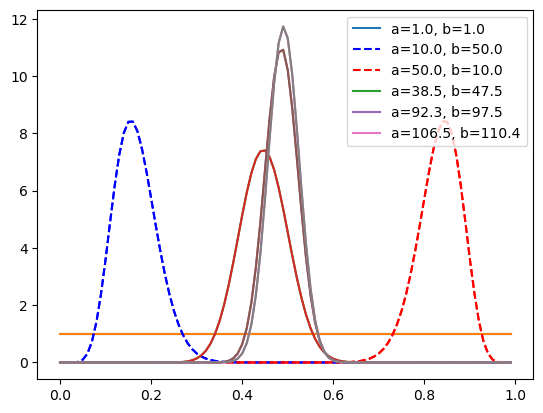

In [17]:
target = Person(1,1)
left_source = Person(10, 50)
right_source = Person(50, 10)

target.plot_beliefs()
left_source.plot_beliefs(style ='b--')
right_source.plot_beliefs(style = 'r--')

target.add_relationship(left_source, 1)
target.add_relationship(right_source, 1)

for t in range(1, 100):
    target.perform_time_step2()
    if t in [5, 20, 50, 100]:
        target.plot_beliefs()

### Two conflicting sources, Equal trust

47.82329224380744 64.46721173136541
103.85278567858968 116.5894183114364
118.12820982912925 130.5100684501937


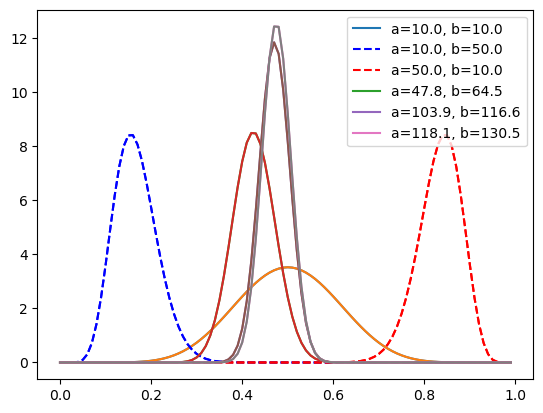

In [18]:
target = Person(10,10)
left_source = Person(10, 50)
right_source = Person(50, 10)

target.plot_beliefs()
left_source.plot_beliefs(style = 'b--')
right_source.plot_beliefs(style = 'r--')

target.add_relationship(left_source, 1)
target.add_relationship(right_source, 1)

for t in range(1, 100):
    target.perform_time_step()
    if t in [5, 20, 50, 100]:
        target.plot_beliefs()
        print(target.alpha, target.beta)

### Conflicting sources, trust left more

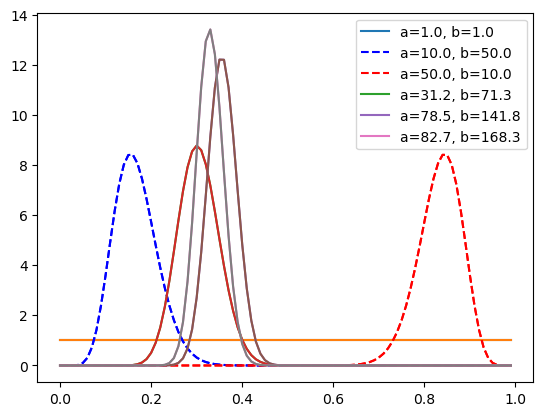

In [19]:
target = Person(1,1)
left_source = Person(10, 50)
right_source = Person(50, 10)

target.plot_beliefs()
left_source.plot_beliefs(style = 'b--')
right_source.plot_beliefs(style = 'r--')

target.add_relationship(left_source, 1, trust=1.5)
target.add_relationship(right_source, 1, trust=0.5)

for t in range(1, 100):
    target.perform_time_step()
    if t in [5, 20, 50, 100]:
        target.plot_beliefs()

### Three sources

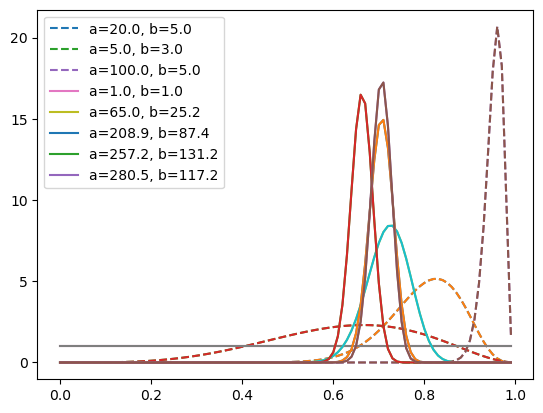

In [20]:
person = Person(1,1)
others = [Person(20, 5), Person(5, 3), Person(100, 5)]
freqs = [0.5, 0.9, 0.1]
mags = [20, 20, 20]
trusts = [1,1,1]

for o, f, m, t in zip(others, freqs, mags, trusts):
    o.plot_beliefs(style = '--')
    person.add_relationship(o, f, m, t)

person.plot_beliefs()
for t in range(1, 101):
    person.perform_time_step()
    if t in [5, 20, 50, 100]:
        person.plot_beliefs()

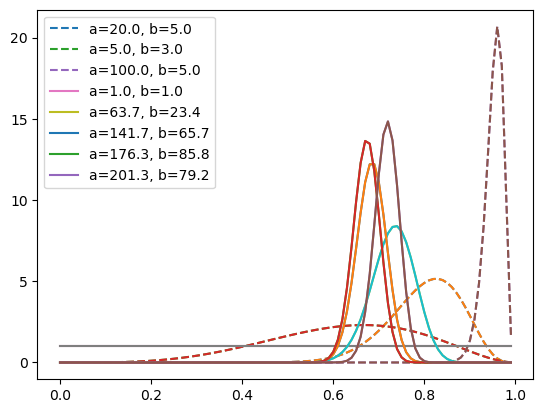

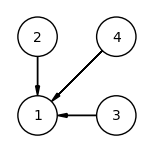

In [21]:
person = Person(1, 1, id_num = 1)
others = [Person(20, 5, id_num = 2), Person(5, 3, id_num = 3), Person(100, 5, id_num = 4)]
freqs = [0.5, 0.9, 0.1]
mags = [20, 20, 20]
trusts = [1,1,1]

for o, f, m, t in zip(others, freqs, mags, trusts):
    o.plot_beliefs(style = '--')
    person.add_relationship(o, f, m, t)

person.plot_beliefs()
for t in range(1, 101):
    person.perform_time_step2()
    if t in [5, 20, 50, 100]:
        person.plot_beliefs()
        
people = [person] + others
visualize_network(people)

### Combined effects of trust and open-mindedness

Parameters were not saved for t=5
Parameters were not saved for t=5
Parameters were not saved for t=25
Parameters were not saved for t=25
Parameters were not saved for t=100
Parameters were not saved for t=100


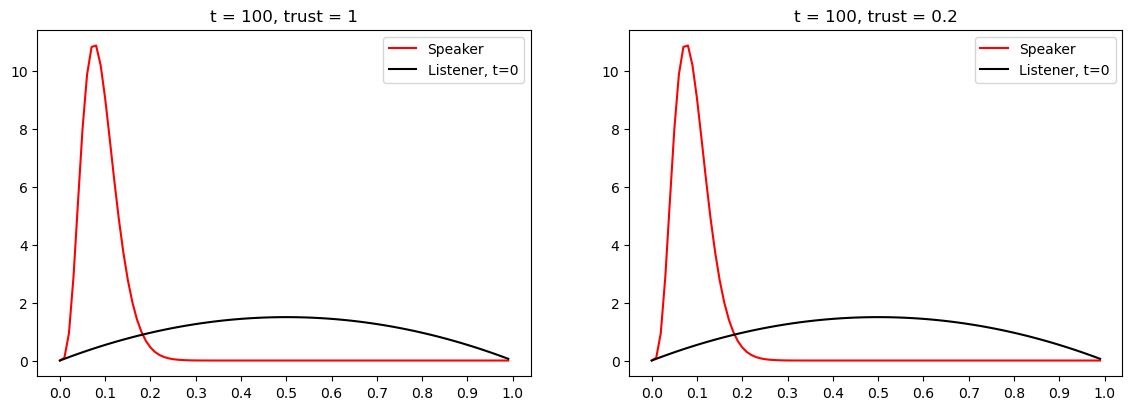

In [22]:
# NOTE: Creates condensed plot for people in cell above
# RUN CELL ABOVE THIS FIRST

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4.5))

ax[0].set_title('t = 100, trust = 1')
ax[1].set_title('t = 100, trust = 0.2')

source_1.plot_beliefs(ax[0], style='r', legend="Speaker")
source_2.plot_beliefs(ax[1], style='r', legend="Speaker")

styles = ['-', '--', '-.', ':']

for i, t in enumerate(recorded_times):
  target_1.plot_beliefs(ax[0], t, "k"+styles[i%len(styles)], f"Listener, t={t}")
  target_2.plot_beliefs(ax[1], t, "k"+styles[i%len(styles)], f"Listener, t={t}")

10
0.2
t=5: a=4.1, b=11.7
t=20: a=9.0, b=32.1
t=50: a=10.6, b=47.7
t=100: a=13.1, b=49.5


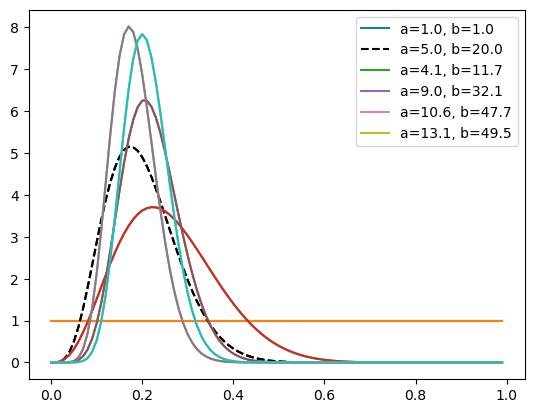

In [23]:
target = Person(1, 1)

source = Person(5, 20)

target.plot_beliefs()
source.plot_beliefs(style = 'k--')

target.add_relationship(source, 1, trust=0.2)
print(list(target.relationships)[0].magnitude)
print(list(target.relationships)[0].trust)

for t in range(1,101):
    target.perform_time_step()
    #print(target.alpha, target.beta)
    if t in [5, 20, 50, 100]:
        print(f"t={t}: a={target.alpha:.1f}, b={target.beta:.1f}")
        target.plot_beliefs()

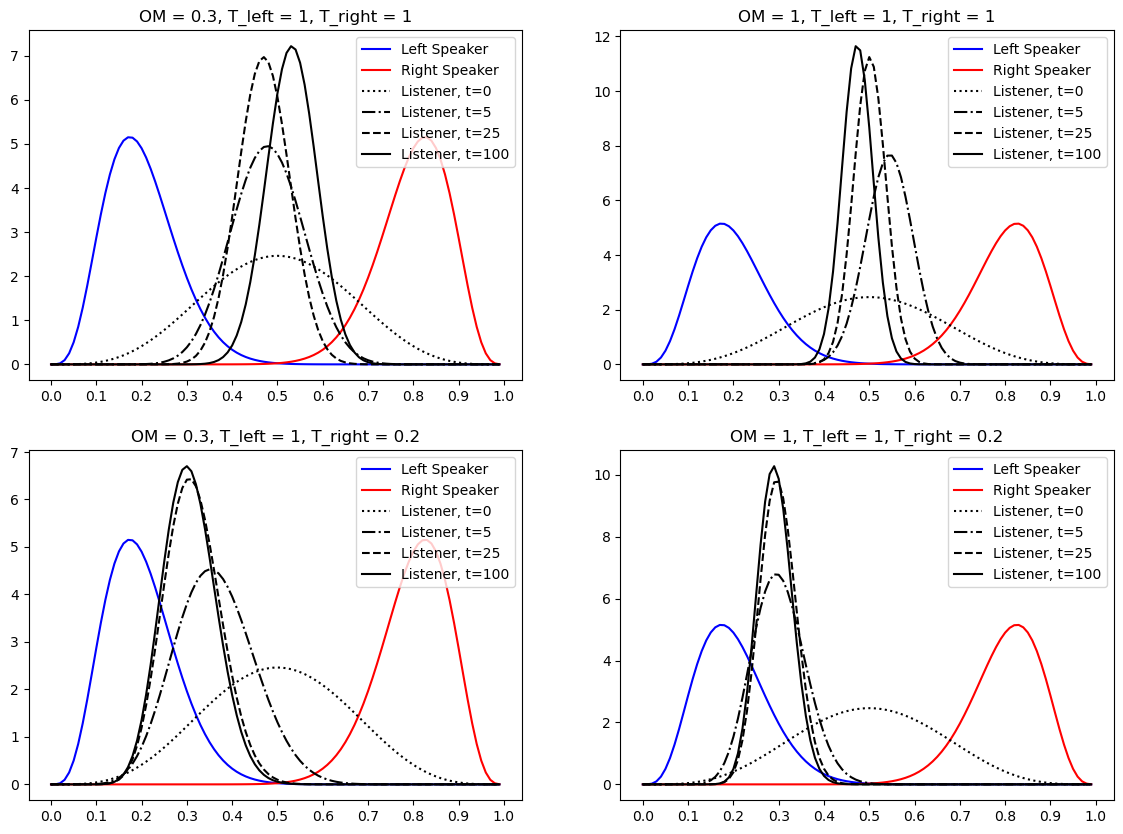

In [24]:
target_1 = Person(5, 5, open_mindedness = 0.3)
target_2 = Person(5, 5, open_mindedness = 1)
target_3 = Person(5, 5, open_mindedness = 0.3)
target_4 = Person(5, 5, open_mindedness = 1)

source_left = Person(5, 20)
source_right = Person(20, 5)

target_1.add_relationship(source_left, 1, trust = 1)
target_2.add_relationship(source_left, 1, trust = 1)
target_3.add_relationship(source_left, 1, trust = 1)
target_4.add_relationship(source_left, 1, trust = 1)

target_1.add_relationship(source_right, 1, trust = 1)
target_2.add_relationship(source_right, 1, trust = 1)
target_3.add_relationship(source_right, 1, trust = 0.2)
target_4.add_relationship(source_right, 1, trust = 0.2)

targets = [target_1, target_2, target_3, target_4]
recorded_times = [0, 5, 25, 100]
run_simulation(targets, targets, 100, recorded_times)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

styles = [':', '-.', '--', '-']

ax[0,0].set_title('OM = 0.3, T_left = 1, T_right = 1')
ax[0,1].set_title('OM = 1, T_left = 1, T_right = 1')
ax[1,0].set_title('OM = 0.3, T_left = 1, T_right = 0.2')
ax[1,1].set_title('OM = 1, T_left = 1, T_right = 0.2')

source_left.plot_beliefs(ax[0,0], 0, "b", "Left Speaker")
source_left.plot_beliefs(ax[0,1], 0, "b", "Left Speaker")
source_left.plot_beliefs(ax[1,0], 0, "b", "Left Speaker")
source_left.plot_beliefs(ax[1,1], 0, "b", "Left Speaker")

source_right.plot_beliefs(ax[0,0], 0, "r", "Right Speaker")
source_right.plot_beliefs(ax[0,1], 0, "r", "Right Speaker")
source_right.plot_beliefs(ax[1,0], 0, "r", "Right Speaker")
source_right.plot_beliefs(ax[1,1], 0, "r", "Right Speaker")


for i, t in enumerate(recorded_times):
  target_1.plot_beliefs(ax[0,0], t, "k"+styles[i%len(styles)], f"Listener, t={t}")
  target_2.plot_beliefs(ax[0,1], t, "k"+styles[i%len(styles)], f"Listener, t={t}")
  target_3.plot_beliefs(ax[1,0], t, "k"+styles[i%len(styles)], f"Listener, t={t}")
  target_4.plot_beliefs(ax[1,1], t, "k"+styles[i%len(styles)], f"Listener, t={t}")



### Trying a large network

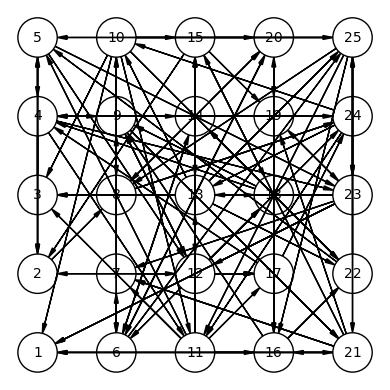

In [25]:
people = []
for i in range(1,26):
    people.append(Person(np.random.rand() * 20, np.random.rand() * 20, id_num = i))
    
for i in range(25):
    for j in range(5):
        other = np.random.randint(1, 25)
        if other != i:
            people[i].add_relationship(people[other], 1)

visualize_network(people)

### Mutual conversation

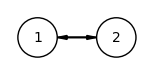

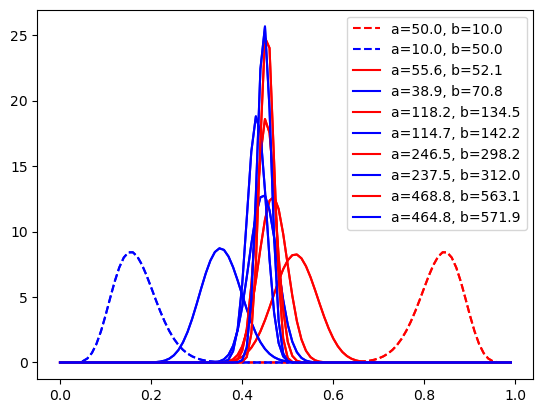

In [26]:
people = [Person(50, 10, id_num=1), Person(10, 50, id_num=2)]

people[0].add_relationship(people[1], 1)
people[1].add_relationship(people[0], 1)

visualize_network(people)

people[0].plot_beliefs(style = "r--")
people[1].plot_beliefs(style = "b--")

for t in range(1,101):
    people[0].perform_time_step()
    people[1].perform_time_step()
    if t in [5, 20, 50, 100]:
        people[0].plot_beliefs(style = "r")
        people[1].plot_beliefs(style = 'b')

### Mutual Conversation, Different Trust

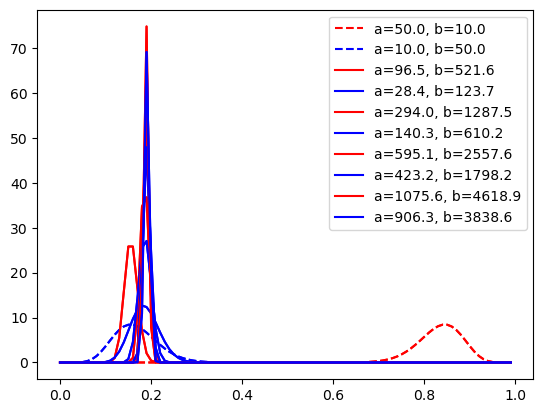

In [27]:
people = [Person(50, 10), Person(10, 50)]

people[0].add_relationship(people[1], 1, trust=20)
people[1].add_relationship(people[0], 1, trust=0.5)

people[0].plot_beliefs(style = "r--")
people[1].plot_beliefs(style = "b--")

for t in range(1,101):
    people[0].perform_time_step2()
    people[1].perform_time_step2()
    if t in [5, 20, 50, 100]:
        people[0].plot_beliefs(style = "r")
        people[1].plot_beliefs(style = 'b')

### One "Bridge" Person

#### Bridge person connected to two groups with similar trusts and frequencies. Bridge person starts at the middle Both groups similar distances from the middle.

In [28]:
center_id = 1
left_group_ids = [i for i in range(2,10)]
right_group_ids = [i for i in range(10, 18)]

center = Person(5, 5, id_num=1)
left_group = [Person(np.random.randint(1,25), np.random.randint(25, 100), id_num=i) for i in left_group_ids]
right_group = [Person(np.random.randint(25, 100), np.random.randint(1,25), id_num=i) for i in right_group_ids]

# add relationships within left_group
for person in left_group:
  for other in np.random.choice(left_group, size=np.random.randint(1, len(left_group_ids)), replace=False):
    if other != person:
      person.add_relationship(other, freq=np.random.uniform(0.5, 1), mag=np.random.randint(15,25), trust=np.random.uniform(0.8, 2))

for person in np.random.choice(left_group, size=np.random.randint(3, 6), replace=False):
  f = np.random.uniform(0.3, 0.7)
  person.add_relationship(center, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.7, 1.3))
  center.add_relationship(person, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.7, 1.3))

# add_relationships within right_group
for person in right_group:
  for other in np.random.choice(right_group, size=np.random.randint(1, len(right_group_ids)), replace=False):
    if other != person:
      person.add_relationship(other, freq=np.random.uniform(0.5,1), mag=np.random.randint(15,25), trust=np.random.uniform(0.8, 2))

for person in np.random.choice(right_group, size=np.random.randint(3, 6), replace=False):
  f = np.random.uniform(0.3, 0.7)
  person.add_relationship(center, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.7, 1.3))
  center.add_relationship(person, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.7, 1.3))

# add relationship with a few people from each group to the center person
people = [center] + left_group + right_group
visualize_network2(people)

In [29]:
# NOTE: this cell is continuation of the cell above, run that first

left_person = np.random.choice(left_group)
right_person = np.random.choice(right_group)
center_person = center

recording_people = left_group + right_group + [center_person]

plotting_people = [left_person, center_person, right_person]

recording_times = [0, 5, 25, 100]
run_simulation(people, recording_people, 101, recording_times)

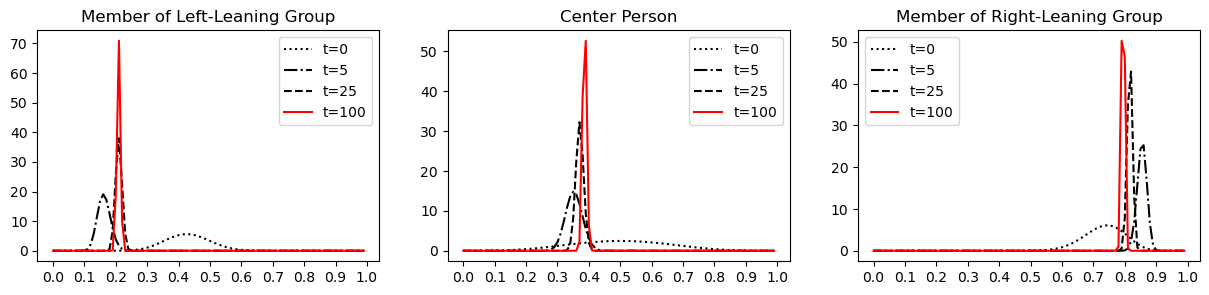

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

axes[0].set_title("Member of Left-Leaning Group")
axes[1].set_title("Center Person")
axes[2].set_title("Member of Right-Leaning Group")

styles = ['k:', 'k-.', 'k--', 'r-']

for i, person in enumerate(plotting_people):
  for j, t in enumerate(recording_times):
    person.plot_beliefs(axes[i], t, styles[j], f"t={t}")


In [31]:
# a list of nodes (people) is needed to use this function

def plot_group_beliefs(people, plotting_times, title = 'No Title'):

  styles = ['k:', 'k-.', 'k--', 'r-']

  for i, t in enumerate(plotting_times):
    group_alphas = []
    group_betas = []
    group_ns = []

    legend = []
    for j in range(len(plotting_times)):
      legend.append(f't = {plotting_times[j]}')

    for person in people:
      group_alphas.append(person.historical_alphas[t])
      group_betas.append(person.historical_betas[t])
      group_ns.append(person.historical_alphas[t] + person.historical_betas[t])

    group_alpha = np.mean(group_alphas)
    group_beta = np.mean(group_betas)

    plot_beta(group_alpha, group_beta, title = f't = {t}', style = styles[i%len(styles)])
    plt.title(title)
    plt.legend(legend)



  

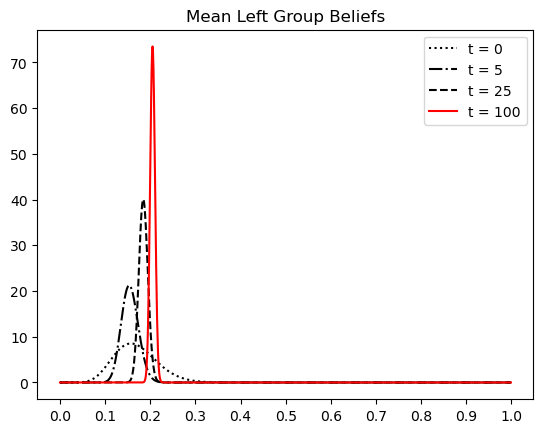

In [32]:
plot_group_beliefs(left_group, plotting_times = recording_times, title = 'Mean Left Group Beliefs')

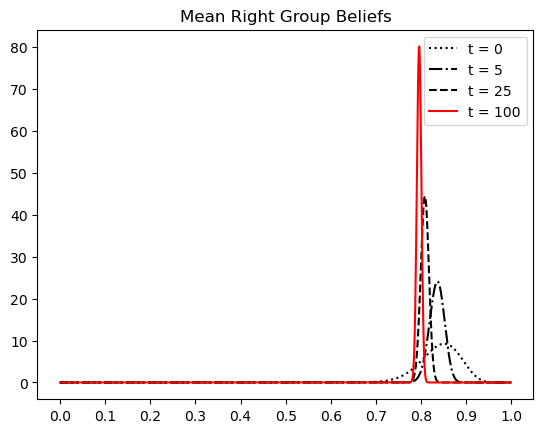

In [33]:
plot_group_beliefs(right_group, plotting_times = recording_times, title = 'Mean Right Group Beliefs')

#### Bridge person connected to two groups with similar trusts but different frequencies. Bridge person starts similar to one group, who they now talk to less often. Both groups similar distances from the middle.

In [34]:
center_id = 1
left_group_ids = [i for i in range(2,10)]
right_group_ids = [i for i in range(10, 18)]

center = Person(100, 5, id_num=1)
left_group = [Person(np.random.randint(1,25), np.random.randint(25, 100), id_num=i) for i in left_group_ids]
right_group = [Person(np.random.randint(25, 100), np.random.randint(1,25), id_num=i) for i in right_group_ids]

# add relationships within left_group
for person in left_group:
  for other in np.random.choice(left_group, size=np.random.randint(1, len(left_group_ids)), replace=False):
    if other != person:
      person.add_relationship(other, freq=np.random.uniform(0.5, 1), mag=np.random.randint(15,25), trust=np.random.uniform(0.8, 2))

for person in np.random.choice(left_group, size=np.random.randint(3, 6), replace=False):
  f = np.random.uniform(0.4, 0.8)
  person.add_relationship(center, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.7, 1.3))
  center.add_relationship(person, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.7, 1.3))

# add_relationships within right_group
for person in right_group:
  for other in np.random.choice(right_group, size=np.random.randint(1, len(right_group_ids)), replace=False):
    if other != person:
      person.add_relationship(other, freq=np.random.uniform(0.5,1), mag=np.random.randint(15,25), trust=np.random.uniform(0.8, 2))

for person in np.random.choice(right_group, size=np.random.randint(3, 6), replace=False):
  f = np.random.uniform(0.1, 0.2)
  person.add_relationship(center, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.7, 1.3))
  center.add_relationship(person, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.7, 1.3))

# add relationship with a few people from each group to the center person
people = [center] + left_group + right_group
visualize_network2(people)

In [ ]:
# NOTE: this cell is continuation of the cell above, run that first

left_person = np.random.choice(left_group)
right_person = np.random.choice(right_group)
center_person = center

recording_people = left_group + right_group + [center_person]

plotting_people = [left_person, center_person, right_person]

recording_times = [0, 5, 25, 100]
run_simulation(people, recording_people, 101, recording_times)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

axes[0].set_title("Member of Left-Leaning Group")
axes[1].set_title("Center Person")
axes[2].set_title("Member of Right-Leaning Group")

styles = ['k:', 'k-.', 'k--', 'r-']

for i, person in enumerate(plotting_people):
  for j, t in enumerate(recording_times):
    person.plot_beliefs(axes[i], t, styles[j], f"t={t}")


In [ ]:
plot_group_beliefs(left_group, plotting_times = recording_times, title = 'Mean Left Group Beliefs')

In [ ]:
plot_group_beliefs(right_group, plotting_times = recording_times, title = 'Mean Right Group Beliefs')

### Modeling News Media

#### Two dominant sources that reach a lot of people in a large network. Both have similar ideologies.

In [ ]:
def visualize_network3(people, highlight_nodes=None):
    df = create_edge_df(people)
    D = nx.DiGraph()
    D.add_nodes_from([p.id for p in people])
    for person in people:
        for r in person.relationships:
            D.add_edge(r.other.id, person.id)
    G = nx.from_pandas_edgelist(df, source="Source", target="Target", edge_attr="Trust")
    
    # Set node colors
    node_colors = {}
    for node in G.nodes():
        if highlight_nodes and node in highlight_nodes:
            node_colors[node] = 'red'
        else:
            node_colors[node] = '#97C2FC'
    nx.set_node_attributes(G, node_colors, 'color')
    
    net = Network(notebook=True, cdn_resources='in_line')
    net.from_nx(G)
    net.show_buttons(filter_=['physics'])
    html = net.generate_html()
    with open("example.html", mode='w', encoding='utf-8') as fp:
        fp.write(html)
    display(HTML(html))


In [ ]:
right_source = Person(400, 50, id_num = 1)
other_right_source = Person(100, 15, id_num = 2)

group_ids = range(3,50)
group = [Person(np.random.randint(60,160), np.random.randint(60, 160), open_mindedness = np.random.uniform(0.01,1), id_num=i) for i in group_ids]

# add relationships within the group
for person in group:
  for other in np.random.choice(group, size=np.random.randint(1, 6), replace=False):
    if other != person:
      person.add_relationship(other, freq=np.random.uniform(0.5, 1), mag=np.random.randint(5,10), trust=np.random.uniform(0.5, 2))


for person in np.random.choice(group, size=np.random.randint(25, 35), replace=False):
  f = np.random.uniform(0.7, 0.9)
  person.add_relationship(right_source, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.4, 1))

for person in np.random.choice(group, size=np.random.randint(25, 35), replace=False):
  f = np.random.uniform(0.7, 0.9)
  person.add_relationship(other_right_source, freq=f, mag=np.random.randint(5,15), trust=np.random.uniform(0.4, 1))

# add relationship with a few people from each group to the center person
people = [right_source] + [other_right_source] + group
visualize_network3(people, highlight_nodes = [1, 2])

In [ ]:
# NOTE: this cell is continuation of the cell above, run that first

person_1 = np.random.choice(group)
person_2 = np.random.choice(group)

recording_people = group + [person_1] + [person_2]

plotting_people = [person_1, person_2]

recording_times = [0, 5, 25, 100]
run_simulation(people, recording_people, 101, recording_times)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))

axes[0].set_title("Random Person 1")
axes[1].set_title("Random Person 2")

styles = ['k:', 'k-.', 'k--', 'r-']

for i, person in enumerate(plotting_people):
  for j, t in enumerate(recording_times):
    person.plot_beliefs(axes[i], t, styles[j], f"t={t}")

In [ ]:
plot_group_beliefs(group, plotting_times = recording_times, title = 'Mean Group Beliefs')

### Modeling Party Association. Are political parties more effective at propagating political beliefs than individual people?

#### Political Party Simulation

In [ ]:
right_extremist_1 = Person(400, 50, id_num = 1)
right_extremist_2 = Person(400, 50, id_num = 2)
right_extremist_3 = Person(400, 50, id_num = 3)
right_extremist_4 = Person(400, 50, id_num = 4)
right_extremist_5 = Person(400, 50, id_num = 5)
right_extremist_6 = Person(400, 50, id_num = 6)
right_extremist_7 = Person(400, 50, id_num = 7)
right_extremist_8 = Person(400, 50, id_num = 8)

right_extremists = [right_extremist_1, right_extremist_2, right_extremist_3, right_extremist_4, right_extremist_5, right_extremist_6, right_extremist_7, right_extremist_8]

group_ids = range(8,60)
group = [Person(np.random.randint(20,30), np.random.randint(20, 30), open_mindedness = np.random.uniform(0.01,1), id_num=i) for i in group_ids]

# add relationships within the group
for person in group:
  for other in np.random.choice(group, size=np.random.randint(2, 6), replace=False):
    if other != person:
      person.add_relationship(other, freq=np.random.uniform(0.5, 1), mag=np.random.randint(5,10), trust=np.random.uniform(0.5, 2))


for person in np.random.choice(group, size=np.random.randint(10, 15), replace=False):
  f = np.random.uniform(0.7, 0.9)
  person.add_relationship(right_extremist_1, freq=f, mag=np.random.randint(1,5), trust=np.random.uniform(0.5, 2))
  person.add_relationship(right_extremist_2, freq=f, mag=np.random.randint(1,5), trust=np.random.uniform(0.5, 2))
  person.add_relationship(right_extremist_3, freq=f, mag=np.random.randint(1,5), trust=np.random.uniform(0.5, 2))

for person in np.random.choice(group, size=np.random.randint(10, 15), replace=False):
  f = np.random.uniform(0.7, 0.9)
  person.add_relationship(right_extremist_4, freq=f, mag=np.random.randint(1,5), trust=np.random.uniform(0.5, 2))
  person.add_relationship(right_extremist_5, freq=f, mag=np.random.randint(1,5), trust=np.random.uniform(0.5, 2))
  person.add_relationship(right_extremist_6, freq=f, mag=np.random.randint(1,5), trust=np.random.uniform(0.5, 2))

for person in np.random.choice(group, size=np.random.randint(10, 15), replace=False):
  f = np.random.uniform(0.7, 0.9)
  person.add_relationship(right_extremist_7, freq=f, mag=np.random.randint(1,5), trust=np.random.uniform(0.5, 2))
  person.add_relationship(right_extremist_8, freq=f, mag=np.random.randint(1,5), trust=np.random.uniform(0.5, 2))

for right_extremist in right_extremists:
  for other in np.random.choice(right_extremists, size=np.random.randint(3, 6), replace=False):
    if other != right_extremist:
      right_extremist.add_relationship(other, freq=np.random.uniform(0.5, 1), mag=np.random.randint(5,10), trust=np.random.uniform(0.9, 2))
      other.add_relationship(right_extremist, freq=np.random.uniform(0.5, 1), mag=np.random.randint(5,10), trust=np.random.uniform(0.9, 2))
# add relationship with a few people from each group to the center person
people = right_extremists + group
visualize_network3(people, highlight_nodes = [1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# NOTE: this cell is continuation of the cell above, run that first

person = np.random.choice(group)
right_extremist = np.random.choice(right_extremists)

recording_people = group + right_extremists
plotting_people = [person, right_extremist]

recording_times = [0, 50, 100, 250]
run_simulation(people, recording_people, 251, recording_times)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))

axes[0].set_title("Random Person")
axes[1].set_title("Random Right Extremist")

styles = ['k:', 'k-.', 'k--', 'r-']

for i, person in enumerate(plotting_people):
  for j, t in enumerate(recording_times):
    person.plot_beliefs(axes[i], t, styles[j], f"t={t}")

In [ ]:
plot_group_beliefs(group, plotting_times = recording_times, title = 'Mean Group Beliefs for Network 2')

In [ ]:
plot_group_beliefs(right_extremists, plotting_times = recording_times, title = 'Mean Right Extremists Beliefs for Network 2')

#### Spread-out extremists

In [ ]:
right_extremists = []
right_extremists_ids = []

group_without_right_extremists = []

group_ids = range(1,60)
group = [Person(np.random.randint(20,30), np.random.randint(20, 30), open_mindedness = np.random.uniform(0.01,1), id_num=i) for i in group_ids]


# Spreading out the extremists amongst the population
for person in np.random.choice(group, size = 8, replace = False):
  person.alpha = 400
  person.beta = 50
  right_extremists.append(person)
  right_extremists_ids.append(person.id)

for person in group:
  if person.alpha != 400:
    group_without_right_extremists.append(person)

# add relationships within the group
for person in group:
  for other in np.random.choice(group, size=np.random.randint(2, 6), replace=False):
    if other != person:
      person.add_relationship(other, freq=np.random.uniform(0.5, 1), mag=np.random.randint(5,10), trust=np.random.uniform(0.5, 2))
# add relationship with a few people from each group to the center person
people = group
visualize_network3(people, highlight_nodes = right_extremists_ids)

In [ ]:
# NOTE: this cell is continuation of the cell above, run that first

person = np.random.choice(group_without_right_extremists)
right_extremist = np.random.choice(right_extremists)

recording_people = group
plotting_people = [person, right_extremist]

recording_times = [1, 50, 100, 250]
run_simulation(people, recording_people, 251, recording_times)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,3))

axes[0].set_title("Random Person")
axes[1].set_title("Random Right Extremist")

styles = ['k:', 'k-.', 'k--', 'r-']

for i, person in enumerate(plotting_people):
  for j, t in enumerate(recording_times):
    person.plot_beliefs(axes[i], t, styles[j], f"t={t}")

In [ ]:
plot_group_beliefs(group_without_right_extremists, plotting_times = recording_times, title = 'Mean Group Beliefs for Network 1')

In [ ]:
plot_group_beliefs(right_extremists, plotting_times = recording_times, title = 'Mean Right Extremists Beliefs for Network 1')

### Bipartite Graph

In [ ]:
left_group_ids = [i for i in range(1,11)]
right_group_ids = [i for i in range(11, 21)]

left_group = [Person(np.random.randint(1,25), np.random.randint(25, 100), id_num=i) for i in left_group_ids]
right_group = [Person(np.random.randint(25, 100), np.random.randint(1,25), id_num=i) for i in right_group_ids]

# add relationships from right group to left group
for person in left_group:
  for other in np.random.choice(right_group, size=np.random.randint(1, len(left_group_ids)), replace=False):
    person.add_relationship(other, 1)

# add relationships from left group to right group
for person in right_group:
  for other in np.random.choice(left_group, size=np.random.randint(1, len(right_group_ids)), replace=False):
    person.add_relationship(other, 1)

people = left_group + right_group
visualize_network2(people)

### Testing Cells, delete later

In [ ]:
a = set([1,2])
b = set([2])
a - b

In [ ]:
Person(10, 100).plot_beliefs()
plt.plot(0.08, 12, 'o')

In [ ]:
sample = stats.beta.rvs(10,200, size=10000)
sample = [stats.bernoulli.rvs(data) for data in sample]
sum(sample)

In [ ]:
beta.rvs(1, 1)